# Import Python libraries for analyzing photos of space rocks

Now that we have all of the libraries downloaded, we can begin importing them into Jupyter Notebook file. We'll begin by opening or creating a Jupyter Notebook file.

Next, we import Matplotlib to help us plot our data:


In [64]:
import matplotlib.pyplot as plt

Then, we import Numpy, a library we'lll use to process large numerical matrixes (images):

In [65]:
import numpy as np

Import PyTorch to train and process deep learning and AI models:

In [66]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

Import torchvision (part of pyTorch) to process images and manipulate them (crop, resize):

In [67]:
import torchvision
from torchvision import datasets, transforms, models

Import Python Imagin Library (PIL) to visualize images:

In [68]:
from PIL import Image

Finally, we add two libraries that ensure that the plots are shown inline and in high resolution:

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import and clean data about photos of space rocks

Now that we know about cleaning and separating the data, we can actually apply these principles to our rock classification project.

Let's start by dowloading all the data we have about rock images. Then, we'll put it in the same folder as you Jupyter Notebook file. Go to [this Azure Blob storage](https://nasadata.blob.core.windows.net/nasarocks/Data.zip) and download the *Data.zip* folder. Unzop it and put it in the same folder as your Jupyter Notebook file.

Because our photos of rocks come in different sizes (small, medium, and large), we crop the imgaes so that they are the same size(22 x 224 pixels). We resize the images because computers expcet images to be same size. If images vary in size, they're not as easy for the computer to process.

We resize the images in the first part of the code. At the bottom of the code, you can see that we separate the data into a training variable and a testing variable.


In [70]:
# Tells the machine what folder contains the image data.
data_dir = './data'

# Function to read the data; crop and resize the images; and then split it into test an train chunks.

def load_split_train_test(datadir, valid_size = .2):
# This line of code transforms the images.
    train_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])

    test_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        ])
                                        
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    import torch
    from torch.utils.data import DataLoader
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# We're using 20% of data for testing.

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Highland']


# How a computer reads a photo as an image file

Now that we have our data cleaned and separated, you migh twonder how to computer reads these images. As somewhat of a spoiler, computer cn't read images the same way you or I see images.

If you know something about computers, you know that computers read things in binary: 1s and 0s. So, how can a computer read a complex image as only 1s and 0s? If you break down an image for enough, it too, is just a combination of 1s and 0s.

An image will look like the following example after a computer transforms them into numbers.

The image is broken down into pixels, and each pixel has a specific color that is identified by a code. After a computer breaks down an image into these codes, it can read and decipher the image.

# Display photos of space rocks in Jupyter Notebook

Now that we've loaded the images into the computer, let's look at a few of them. We'll give them labels that indicate what type of rock the photos contain.

The following code block reads images and then assigns each image with a correspondng rock type. The code looks long,
but that's because it needs to match each rock image with the type of rock it is, based on the folder it is in.

In [71]:
# Transform the new image into numbers and resize it.

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                    ])

# A function to randomly select a set of images

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classed = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

The following code actually shows you some images that you loaded into the program:

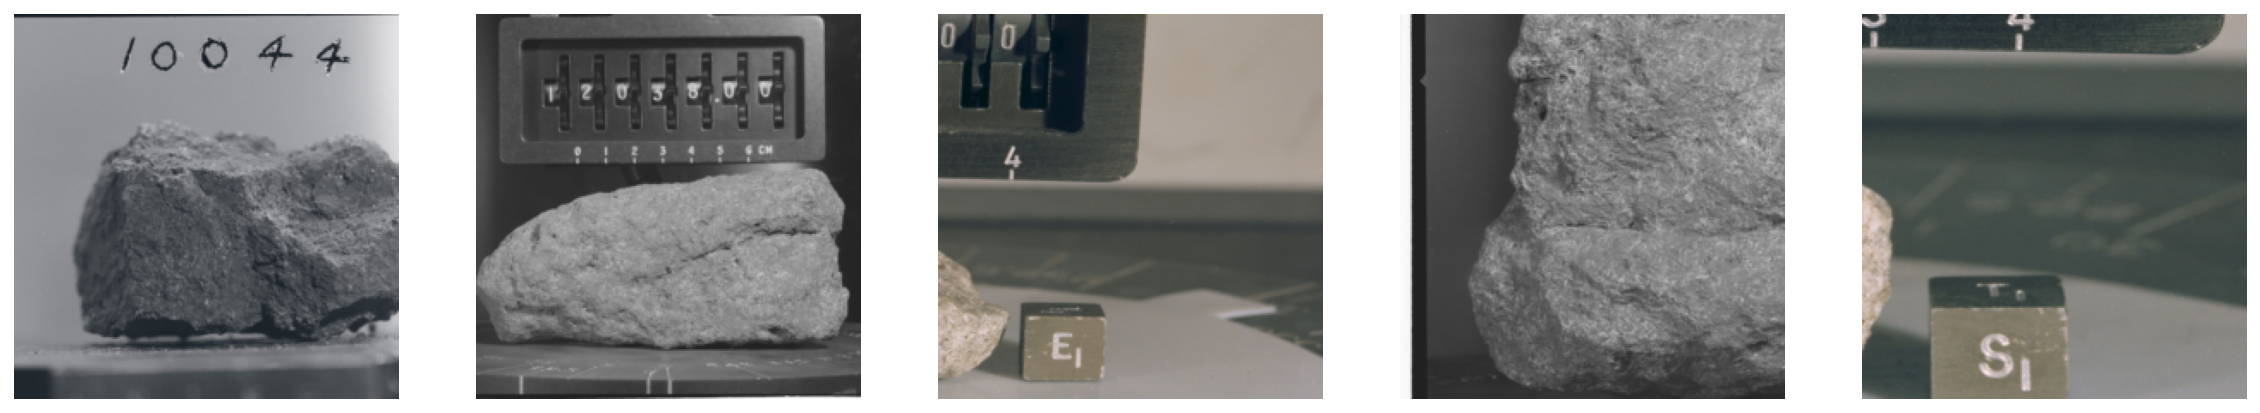

In [72]:
# How many images do you want to see? It's set to 5, but you can change the number

images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig =plt.figure(figsize=(20, 20))
classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

plt.show()

We use the PIL library here to manipulate the iamges, so they look appealing when we print them. We use the plt.show to actually print the images.

# Build a neural network to classify space rocks

Now, let's build a neural network/deep learning network to learn the associations between featuers (for example, curves, edges, and texture) and each rock type.

The way a neural network works is very similar to how our brains work. The human brain consists of neurons or nerve cells that transmit and process information it receives from our senses. Many of the nerve cells are arranged together to form a network of nerves in our brain. The nerves pass electrical impulses from one neuron to next neuron.

Run the following code to tell your cimputer the most efficient way to create a neural network:

In [73]:
# Determine wheter you're usinga CPU or a GPU to build the deep learnig network.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


Neural networks have millions of neurons and nerves. To build a functional neural network, we wire them together in two steps:

1. Build all the neurons.
2. Wire the neurons in an appropriate way (there are thousands of ways to wire neurons).


In [74]:
# Builds all the neurons

for param in model.parameters():
    param.requires_grad = False

# The parameters of our deep learning model.

model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 2),
                        nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


The neural network goes back and forth many times until it learns the best associations (wiring) between features and rock types.

# Train a neural network to accurately classify space rocks in photos

Now that we have built a neural network and introduced the program to the diffrent featuers of the rocks, we must now train the program In this step, we use our training data to make our program very accurate in classifying space rocks.

Copy the following code into a cell, and then run it. One thing to look for in this code is the ```epochs``` variable. This variable tells the program how many times to search for associations in features. It's initially set to 5, but you can increase the accuracy. However, increasing the number makes the cod run signigcantly slower.

In [75]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:

        steps += 1
        print("Training step", steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()

            with torch.no_grad():

                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            
            print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/print_every:.3f}.. "
            f"Test loss: {test_loss/len(testloader):.3f}.. "
            f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            model.train()
            



Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Epoch 1/5.. Train loss: 1.752.. Test loss: 0.676.. Test accuracy: 0.552
Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Epoch 2/5.. Train loss: 0.767.. Test loss: 0.428.. Test accuracy: 0.871
Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Epoch 2/5.. Train loss: 0.423.. Test loss: 0.403.. Test accuracy: 0.838
Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Epoch 3/5.. Train loss: 0.477.. Test loss: 0.465.. Test accuracy: 0.777
Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Epoch 4/5.. Train loss: 0.326.. Test loss: 0.486.. Test accuracy: 0.744
Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Epoch 4/5.. Train loss: 0.348.. Test loss: 0.327.. Test accuracy: 0.840
Training step 31
Training step 32
Training step 33
Training step 34

# Determine the accuracy of a neural network in classifying space rocks

A large part of AI is it degree of accuracy in predicting the correct outcome. In our case, accuracy is how likely the ocmputer is to corrctly idenfity a rock that's shown in an image as being the type that scientist have manually determined it is. An accuraccy of 0.96 means that 96% of rock types are predicted correctly and that 4% are misclassified.

The following code calculates the accuracy of our AI system in classifying rocks:


In [76]:
print(accuracy / len(testloader))

0.9375


As you can see, the accuracy of this model is very high. This is what we want, because it means that the model does a good job of making predictions.

Even though 96% is high, you can take a couple more steps to increase accuracy even further:

- Add more iamges, for training the AI models.
- Increase the epoch (number of training iterations for deep learning).

Now that we have created the neural network and tested the accuracy, let's save it:

In [82]:
torch.save(model, 'aerialmodel.pth')

# Predict the type of space rock in a random photo

Let's predict rock types. To predic the type of rock that's shown in a new image, we need to complete the following steops:

1. Conver the new image to numbers.
2. transform the image: crop and resize it to 224 x 224 pixels.
3. Extract the features and characteristics of the image.
4. Predict the type of rock that's shown in the image by suing the associations we learned in step 2.

The following code loads our neural network:

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("aerialmodel.pth")

This code creates a function that predicts the new image type:

In [87]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

# Test a neural network that classifies photos of space rocks

Let's pick five random images and see whetehr our model can tell what type of rock it is.

The following code gets five rnadom images and stores their data in variables. WE use five iamges to test our AI system, but
you can choose any number. After you run the following code, change the number to 10, and then run the code again.

In [89]:
images, labels = get_random_images(5)

This code visualizes the new images and adds captions that indicate what type of rock the model determines the photo contains

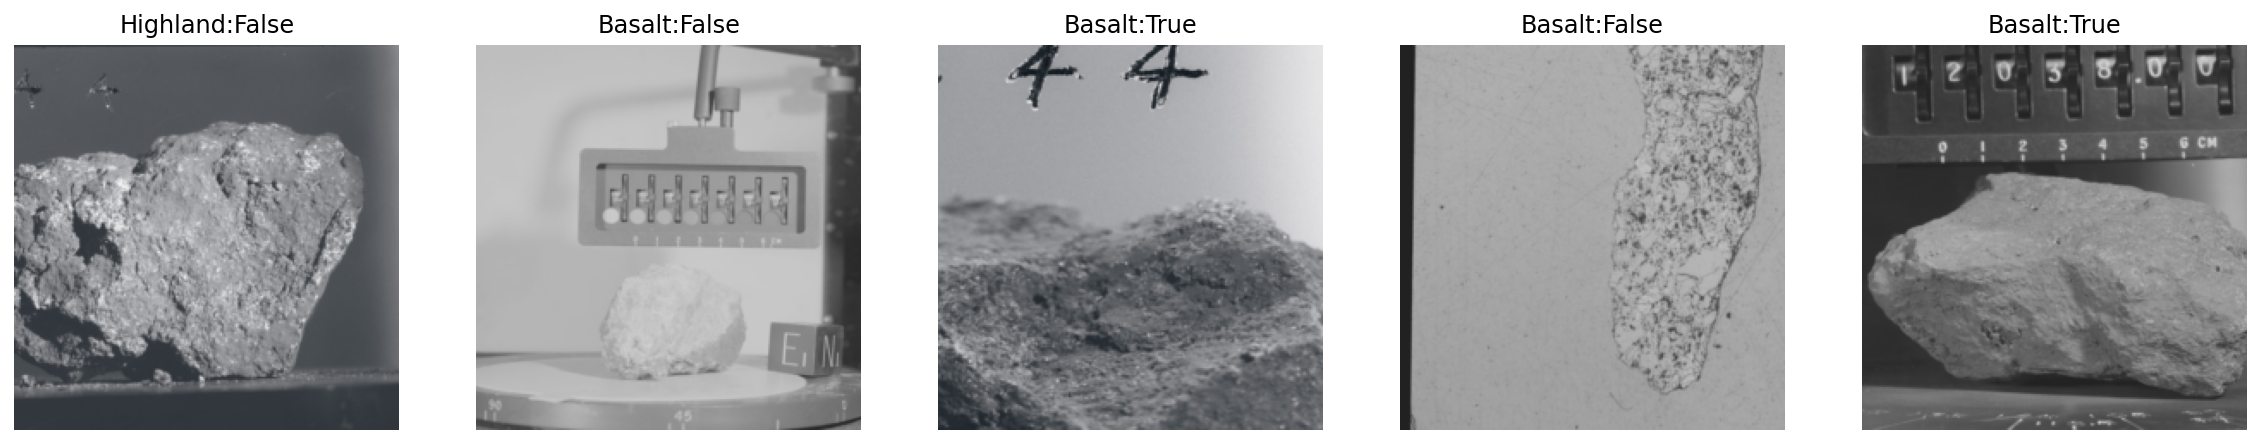

In [92]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize = (20, 10))

classes = trainloader.dataset.classes

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii + 1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res)) 
    plt.axis('off')
    plt.imshow(image)

plt.show()

The example images are labeled *Actual Rock Type: True/False.*

*True* and *False* indicate wheter our AI system correctly classified the rock in an image.